https://www.kaggle.com/bobber/petfinder-fastai-with-dataaugmentation-kfold-10

### Import library 

In [4]:
import sys
from timm import create_model
from fastai.vision.all import *

In [5]:
set_seed(999,reproducible=True)
BATCH_size = 32

In [7]:
dataset_path = Path('./')
dataset_path.ls()

(#8) [Path('test'),Path('train.csv'),Path('train'),Path('fastai_petfinder.ipynb'),Path('test.csv'),Path('sample_submission.csv'),Path('.ipynb_checkpoints'),Path('datasets')]

In [8]:
train_df = pd.read_csv(dataset_path/'train.csv')
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [9]:
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,0,1,1,0,0,0,0,0,0,0,1,50,train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg
1,0,1,1,1,0,1,0,1,0,0,1,0,25,train/25e3bf4267c2dc3f579b779418221bb7.jpg
2,0,0,1,1,0,1,0,0,0,0,0,0,27,train/6548166fb3fda22b67881176397f0223.jpg
3,0,1,1,1,0,0,0,0,1,1,0,0,19,train/472c40116e1833555715e4774445ae5b.jpg
4,0,1,1,1,0,0,0,1,0,0,0,0,27,train/7b77e1a6d93667b575d57db83facd860.jpg


The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577444


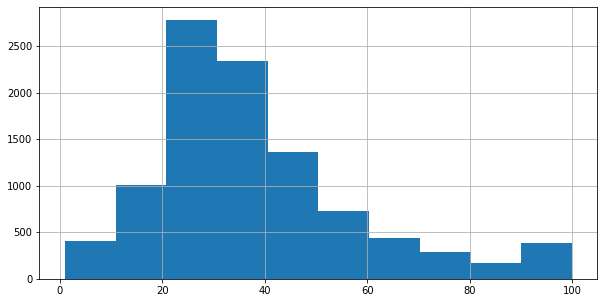

In [10]:
train_df['Pawpularity'].hist(figsize = (10, 5))
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")

In [11]:
len_df = len(train_df)
print(f"There are {len_df} images")

There are 9912 images


In [12]:
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

There are 100 unique values of Pawpularity score


classification 문제로 접근하기 위해 normalize해주기

In [13]:
train_df['norm_score'] = train_df['Pawpularity']/100

In [14]:
im = Image.open(train_df['path'][1])
width,height = im.size
print(width,height)

960 960


### Data Loading

In [15]:
train_df.head()

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score
0,0,0,1,1,0,0,0,0,0,0,0,1,50,train/ebaaa8e384b3d2f0a56c7ff7675c154c.jpg,0.50
1,0,1,1,1,0,1,0,1,0,0,1,0,25,train/25e3bf4267c2dc3f579b779418221bb7.jpg,0.25
2,0,0,1,1,0,1,0,0,0,0,0,0,27,train/6548166fb3fda22b67881176397f0223.jpg,0.27
3,0,1,1,1,0,0,0,0,1,1,0,0,19,train/472c40116e1833555715e4774445ae5b.jpg,0.19
4,0,1,1,1,0,0,0,1,0,0,0,0,27,train/7b77e1a6d93667b575d57db83facd860.jpg,0.27


In [16]:
dls = ImageDataLoaders.from_df(train_df,
                               valid_pct=0.2,
                               seed=999,
                               fn_col='path', #filename/path is in the second column of Dataframe
                               label_col='norm_score',
                               y_block=RegressionBlock, #The type of target
                               bs=32, #batch size
                               num_workers=8,
                               item_tfms=Resize(224),
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()]))
                               

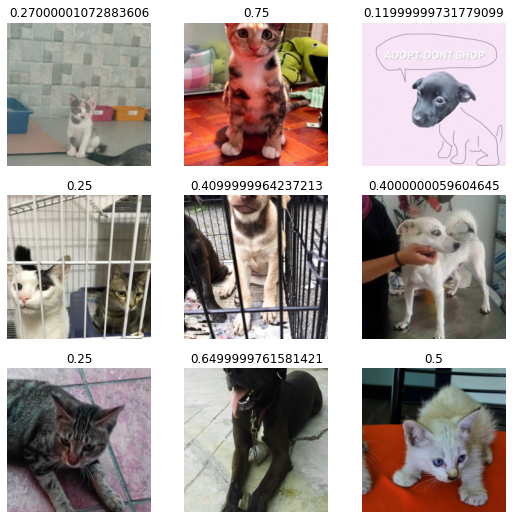

In [17]:
dls.show_batch()

## Model Training

timm lilbrary package에서 pretrained weight download. Internet usable이면 안해도될듯

In [ ]:
# if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
#     os.makedirs('/root/.cache/torch/hub/checkpoints/')
# !cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

In [18]:
model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=dls.c)

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /home/user/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


In [21]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()),target)) #sigmoid(input)과 target의 mse_loss

In [42]:
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16() #fp16으로 하고 나중에 32로 전환

SuggestedLRs(valley=0.00017041253158822656)

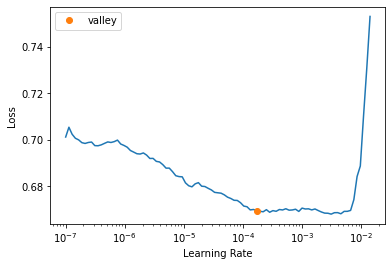

In [24]:
learn.lr_find(end_lr=3e-2)

### Fine-tuning

lr_find를 통해 제안된 2e-5의 lr을 사용하면서, early stopping callback을 이용해서 베스트 모델을 저장해보자

In [44]:
learn.fit_one_cycle(2, 2e-5, cbs=[SaveModelCallback(), 
                                   EarlyStoppingCallback(monitor='petfinder_rmse',comp=np.less,patience=3)])

epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.636720,0.646354,18.194435,01:39
1,0.626957,0.639368,17.407497,01:40


Better model found at epoch 0 with valid_loss value: 0.6463537216186523.
Better model found at epoch 1 with valid_loss value: 0.6393679976463318.


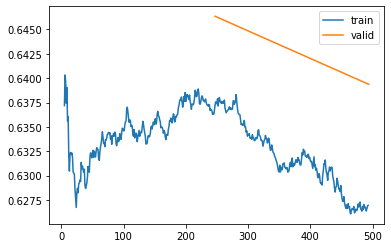

In [45]:
learn.recorder.plot_loss()

In [46]:
learn = learn.to_fp32()

In [47]:
learn.save('fine-tuned')

Path('models/fine-tuned.pth')

In [48]:
learn.export() #pkl 파일로 저장

## Inference

In [51]:
test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [68]:
test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x : str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100
test_dl = dls.test_dl(test_df)

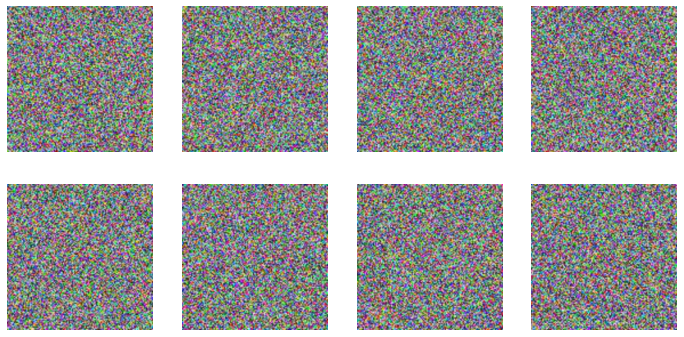

In [71]:
test_dl.show_batch()

In [72]:
preds,_ = learn.tta(dl=test_dl, n=5, beta=0)

In [73]:
preds

tensor([[0.4842],
        [0.4564],
        [0.4758],
        [0.4644],
        [0.4740],
        [0.4537],
        [0.4623],
        [0.4575]])

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['Pawpularity'] = preds.float().numpy()*100
sample_df.to_csv('submission.csv',index=False)